In [4]:
##### # Imports

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# Import Pandas profiling
from pandas_profiling import ProfileReport

In [69]:
def intitial_eda_checks(df):
    '''
    Takes df
    Checks nulls
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('No NaN found.')
        
def view_columns_w_many_nans(df, missing_percent):
    '''
    Checks which columns have over specified percentage of missing values
    Takes df, missing percentage
    Returns columns as a list
    '''
    mask_percent = df.isnull().mean()
    series = mask_percent[mask_percent > missing_percent]
    columns = series.index.to_list()
    print(columns) 
    return columns

def drop_columns_w_many_nans(df, missing_percent):
    '''
    Takes df, missing percentage
    Drops the columns whose missing value is bigger than missing percentage
    Returns df
    '''
    series = view_columns_w_many_nans(df, missing_percent=missing_percent)
    list_of_cols = series
    df_temp=df.drop(columns=list_of_cols)
    print(list_of_cols)
    return df_temp

def histograms_numeric_columns(df_new, numerical_columns):
    '''
    Takes df, numerical columns as list
    Returns a group of histagrams
    '''
    sns.kdeplot(df_new[numerical_columns], bw=1.5)
    f = pd.melt(df_new, value_vars=numerical_columns) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    g = g.map(sns.distplot, 'value')
    return g

def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g

def categorical_to_ordinal_transformer(categories):
    '''
    Returns a function that will map categories to ordinal values based on the
    order of the list of `categories` given. Ex.

    If categories is ['A', 'B', 'C'] then the transformer will map 
    'A' -> 0, 'B' -> 1, 'C' -> 2.
    '''
    return lambda categorical_value: categories.index(categorical_value)

def transform_categorical_to_numercial(df, categorical_numerical_mapping):
    '''
    Transforms categorical columns to numerical columns
    Takes a df, a dictionary 
    Returns df
    '''
    transformers = {k: categorical_to_ordinal_transformer(v) 
                    for k, v in categorical_numerical_mapping.items()}
    new_df = df.copy()
    for col, transformer in transformers.items():
        new_df[col] = new_df[col].map(transformer).astype('int64')
    return new_df

In [5]:
df = pd.read_csv('Dataset/credit_train.csv')

# EDA

In [6]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

In [10]:
print("Data Proportion \n")
df['Loan Status'].value_counts()/len(df)

Data Proportion 



Fully Paid     0.769654
Charged Off    0.225232
Name: Loan Status, dtype: float64

In [12]:
df_new = df.drop(columns = ['Loan ID','Customer ID'])

In [26]:
intitial_eda_checks(df_new)

Total and Percentage of NaN:
                               Total   Percent
Months since last delinquent  53655  0.533806
Credit Score                  19668  0.195674
Annual Income                 19668  0.195674
Years in current job           4736  0.047118
Bankruptcies                    718  0.007143
Tax Liens                       524  0.005213
Maximum Open Credit             516  0.005134
Home Ownership                  514  0.005114
Current Loan Amount             514  0.005114
Term                            514  0.005114
Monthly Debt                    514  0.005114
Purpose                         514  0.005114
Years of Credit History         514  0.005114
Number of Open Accounts         514  0.005114
Number of Credit Problems       514  0.005114
Current Credit Balance          514  0.005114
Loan Status                     514  0.005114


In [40]:
# drop column that have many missing values (>= 50%)
df_new = drop_columns_w_many_nans(df_new, 0.5)
intitial_eda_checks(df_new)

['Months since last delinquent']
['Months since last delinquent']
Total and Percentage of NaN:
                            Total   Percent
Annual Income              19668  0.195674
Credit Score               19668  0.195674
Years in current job        4736  0.047118
Bankruptcies                 718  0.007143
Tax Liens                    524  0.005213
Maximum Open Credit          516  0.005134
Current Credit Balance       514  0.005114
Number of Credit Problems    514  0.005114
Number of Open Accounts      514  0.005114
Years of Credit History      514  0.005114
Monthly Debt                 514  0.005114
Purpose                      514  0.005114
Home Ownership               514  0.005114
Term                         514  0.005114
Current Loan Amount          514  0.005114
Loan Status                  514  0.005114


In [42]:
df_new.head()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0
1,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,0.0
2,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0
3,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0
4,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,0.0


In [54]:
df_new['Loan Status'] = [1 if x == 'Fully Paid' else 0 for x in df_new['Loan Status']]

In [70]:
# We need to convert the values of years in current job into integer format.
df_new['Years in current job'] = df_new['Years in current job'].map({'8 years':8, '10+ years':15,
                                        '3 years':3, '5 years':5, '< 1 year':0.5, 
                            '2 years':2, '4 years':4, '9 years':9, '7 years':7, '1 year':1, '6 years':6})

In [71]:
df['Years in current job'].value_counts()

10+ years    31121
2 years       9134
3 years       8169
< 1 year      8164
5 years       6787
1 year        6460
4 years       6143
6 years       5686
7 years       5577
8 years       4582
9 years       3955
Name: Years in current job, dtype: int64

In [73]:
df_new['Years in current job'].value_counts()

15.0    31121
2.0      9134
3.0      8169
0.5      8164
5.0      6787
1.0      6460
4.0      6143
6.0      5686
7.0      5577
8.0      4582
9.0      3955
Name: Years in current job, dtype: int64

In [74]:
numeric_column = [x for x in df_new.columns if df_new[x].dtypes != 'O']
categorical_column = [x for x in df_new.columns if df_new[x].dtypes == 'O']

# histogram to numeric values

In [75]:
df_new[numeric_column].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Loan Status                100514 non-null  int64  
 1   Current Loan Amount        100000 non-null  float64
 2   Credit Score               80846 non-null   float64
 3   Annual Income              80846 non-null   float64
 4   Years in current job       95778 non-null   float64
 5   Monthly Debt               100000 non-null  float64
 6   Years of Credit History    100000 non-null  float64
 7   Number of Open Accounts    100000 non-null  float64
 8   Number of Credit Problems  100000 non-null  float64
 9   Current Credit Balance     100000 non-null  float64
 10  Maximum Open Credit        99998 non-null   float64
 11  Bankruptcies               99796 non-null   float64
 12  Tax Liens                  99990 non-null   float64
dtypes: float64(12), int64(1)
memo

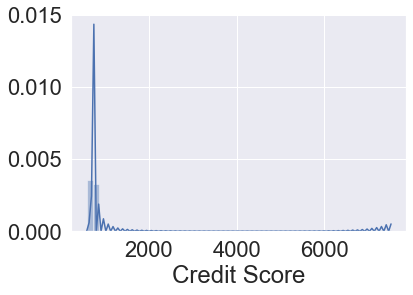

In [78]:
sns.distplot(df_new['Credit Score']) 
plt.show()

In [79]:
df_new['Credit Score'] = [x if x <= 850 else x/10 for x in df_new['Credit Score']]

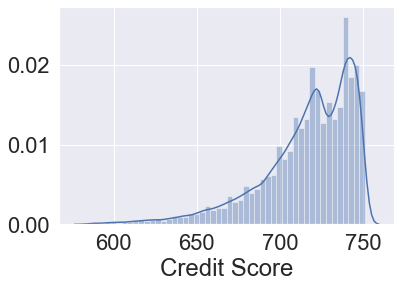

In [80]:
sns.distplot(df_new['Credit Score']) 
plt.show()

# impute the missing value

In [83]:
for x in numeric_column:
    if df_new[x].dtype != 'O':
        df_new[x] = df_new[x].replace([np.nan, -np.inf, np.inf,99999999],[np.nan, np.nan, np.nan, np.nan])
        df_new[x] = df_new[x].fillna(df_new.groupby(['Term','Years in current job','Purpose'])[x].transform('median'))

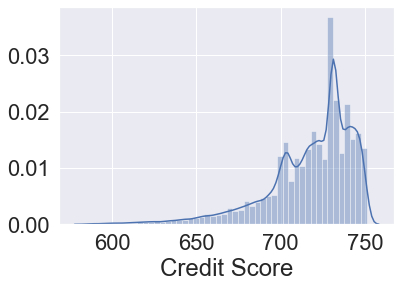

In [84]:
sns.distplot(df_new['Credit Score']) 
plt.show()

In [87]:
# if your computer is too slow, you can replace the numeric data with mean with this code below :
for x in categorical_column:
    if df_new[x].dtype == 'O':
        df_new[x] = df_new[x].fillna(df_new[x].mode()[0])

# feature generation